<a href="https://colab.research.google.com/github/667029/KVP10k/blob/main/LayoutLMv3_KVP10k_GG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#IKKE KJØR DENNE NOTEBOOKEN :)

_______

In [ ]:
!pip install -q transformers datasets seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_6

In [ ]:
!pip install evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.6 MB/s eta 0:00:00


In [7]:
import os              #navigere mapper og filer, hente filbaner
from PIL import Image  #åpne, vise og manipulere bilder
import json            #lese/skrive til JSON-filer
from transformers import LayoutLMv3Processor
import torch
from google.colab import drive

In [8]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
base_path = "/content/drive/MyDrive/DAT255/KVP10k-dataset/kvp10k/"
print(os.listdir(base_path))

['train', 'test']


In [10]:
processor = LayoutLMv3Processor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False) # <-- Viktig fordi vi allerede har utført OCR på bildet og har tekst og bboxes

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/275 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

In [11]:
# Mapping fra tekstlige BIO-labels til tall som modellen bruker
label_map = {
    "O": 0,
    "B-KEY": 1,
    "I-KEY": 2,
    "B-VALUE": 3,
    "I-VALUE": 4,
}

# Funksjon for å skalere bounding boxes til 0-1000 (som LayoutLMv3 krever)
def normalize_bbox(bbox, width, height):
  return [
      int(1000 * (bbox[0] /width)),
      int(1000 * (bbox[1] / height)),
      int(1000 * (bbox[2] / width)),
      int(1000 * (bbox[3] / height))
  ]


def assign_label_for_box(box, boxes, label_type):
  """Returnerer liste med (index, label) for tokens som overlapper box"""
  overlaps = []
  for i, token_box in enumerate(boxes):
    if box_overlap(box, token_box) > 0:
      overlaps.append(i)

  overlaps = sorted(overlaps)

  labeled = []
  for j, idx in enumerate(overlaps):
    tag = f"B-{label_type}" if j == 0 else f"I-{label_type}"
    labeled.append((idx, tag))

  return labeled


#Sjekker om OCR-boksen overlapper med GTS(key/value)-boksen.
#Ved overlapp hører de til hverandre.
def box_overlap(box1, box2):
  x0 = max(box1[0], box2[0])
  y0 = max(box1[1], box2[1])
  x1 = min(box1[2], box2[2])
  y1 = min(box1[3], box2[3])
  return max(0, x1 - x0) * max(0, y1 - y0)


# Funksjon for å generere BIO-labels fra gts (ground truth).
# Lager en BIO-label for hvert token basert på om det overlapper med en key- eller value-boks fra GTS.
# Matcher hvert token fra OCR (word + bbox) mot key/value-bbokser fra gts:
# --> Token overlapper en nøkkelboks: B-KEY eller I-KEY
# --> Token overlapper en verdiboks: B-VALUE eller I-VALUE
# --> Ellers: O
def iob_from_kvps(words, boxes, kvps):
  labels = ["O"] * len(words)

  #Gå igjennom alle key-value-pairs
  for kvp in kvps:
    if "key" in kvp and "bbox" in kvp["key"]:
      key_bbox = kvp["key"]["bbox"]
      for idx, tag in assign_label_for_box(key_bbox, boxes, "KEY"):
        labels[idx] = tag

    if "value" in kvp and "bbox" in kvp["value"]:
      value_box = kvp["value"]["bbox"]
      for idx, tag in assign_label_for_box(value_box, boxes, "VALUE"):
        labels[idx] = tag

  return labels

In [12]:
!ls -lh /content/drive/MyDrive/KVP10k_processed_ready


total 13K
-rw------- 1 root root   37 Apr  9 15:55 dataset_dict.json
drwx------ 2 root root 4.0K Apr  9 15:55 eval
drwx------ 2 root root 4.0K Apr  9 15:55 test
drwx------ 2 root root 4.0K Apr  9 15:55 train


In [13]:
from google.colab import drive
from datasets import load_from_disk

# Monter Drive (hvis du ikke har gjort det)
drive.mount("/content/drive", force_remount=True)

# Last inn dataset fra riktig path
dataset = load_from_disk("/content/drive/MyDrive/KVP10k_processed_ready")

# Hent splits
train_dataset = dataset["train"]
eval_dataset = dataset["eval"]
test_dataset = dataset["test"]

# (Valgfritt) Gjør klar for huggingface Trainer
train_dataset.set_format("torch")
eval_dataset.set_format("torch")
test_dataset.set_format("torch")

# Sjekk at alt fungerer
print("✅ Datasett lastet inn!")
print("Train:", len(train_dataset))
print("Eval:", len(eval_dataset))
print("Test:", len(test_dataset))
print("Keys:", train_dataset[0].keys())

ModuleNotFoundError: No module named 'datasets'

In [ ]:
train_dataset.features

{'pixel_values': Array3D(shape=(3, 224, 224), dtype='float32', id=None),
 'input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'bbox': Array2D(shape=(512, 4), dtype='int64', id=None),
 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}

In [ ]:
example = train_dataset[0]
for k,v in example.items():
    print(k,v.shape)

pixel_values torch.Size([3, 224, 224])
input_ids torch.Size([512])
attention_mask torch.Size([512])
bbox torch.Size([512, 4])
labels torch.Size([512])


In [ ]:
processor.tokenizer.decode(train_dataset[0]["input_ids"])

'<s> ¢DiHeart Invoice Number: 6418976968 Invoice Details Order Line Product Type Ordered Day(s) Daypart Rate Spot Commercial CAS60R9336H / CAS60R9336H 7/26/2022 3:16 pm 60 $115.00 Spot Commercial CASB0R9336H / CAS60R9336H 7/26/2022 4:48 pm 60 $115.00 Spot Commercial CAS60R9347H / CAS60R9347H 7/27/2022 5:29 pm 60 $115.00 Spot Commercial CAS60R9347H / CAS60R9347H 7/28/2022 6:55 pm 60 $115.00 Spot Commercial CAS60R9347H / CAS60R9347H 7/29/2022 6:20 pm 60 $115.00 Totals for Station: ~~ KDON-FM ~~ No.of SpotsMisc: ~~ 870 GrossAmt $9,19500 Totals for Market: Monterey No. of Spots/Misc: 87/0 Gross Amt: $9,195.00 Totals for Invoice: No. of Spots/Misc: 87/0 Gross Amt: $9,195.00 Page 5 of 5</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><p

In [ ]:
for id, label in zip(train_dataset[0]["input_ids"], train_dataset[0]["labels"]):
  print(processor.tokenizer.decode([id]), label.item())

<s> -100
 � 3
� 3
Di -100
Heart -100
 Inv 1
oice -100
 Number 2
: -100
 64 3
18 -100
97 -100
69 -100
68 -100
 Inv 3
oice -100
 Details 4
 Order 0
 Line 0
 Product 0
 Type 0
 Ord 0
ered -100
 Day 0
( -100
s -100
) -100
 Day 0
part -100
 Rate 0
 Spot 0
 Commercial 0
 CAS 0
60 -100
R -100
9 -100
336 -100
H -100
 / 0
 CAS 0
60 -100
R -100
9 -100
336 -100
H -100
 7 0
/ -100
26 -100
/ -100
20 -100
22 -100
 3 0
: -100
16 -100
 pm 0
 60 0
 $ 0
115 -100
. -100
00 -100
 Spot 0
 Commercial 0
 CAS 0
B -100
0 -100
R -100
9 -100
336 -100
H -100
 / 0
 CAS 0
60 -100
R -100
9 -100
336 -100
H -100
 7 0
/ -100
26 -100
/ -100
20 -100
22 -100
 4 0
: -100
48 -100
 pm 0
 60 0
 $ 0
115 -100
. -100
00 -100
 Spot 0
 Commercial 0
 CAS 0
60 -100
R -100
9 -100
347 -100
H -100
 / 0
 CAS 0
60 -100
R -100
9 -100
347 -100
H -100
 7 0
/ -100
27 -100
/ -100
20 -100
22 -100
 5 0
: -100
29 -100
 pm 0
 60 0
 $ 0
115 -100
. -100
00 -100
 Spot 0
 Commercial 0
 CAS 0
60 -100
R -100
9 -100
347 -100
H -100
 / 0
 CAS 0
60 -100
R

In [ ]:
from evaluate import load
metric = load("seqeval")

In [ ]:
import numpy as np

label_list = ["O", "B-KEY", "I-KEY", "B-VALUE", "I-VALUE"]
label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for i, label in enumerate(label_list)}


def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [id2label[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [ ]:
from transformers import LayoutLMv3ForTokenClassification

model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base",
                                                         id2label=id2label,
                                                         label2id=label2id)

config.json:   0%|          | 0.00/856 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments

train_args = TrainingArguments(
    output_dir="test",
    num_train_epochs=8,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,
    learning_rate=5e-6,
    weight_decay=0.01,
    evaluation_strategy="steps",
    eval_steps=125,
    save_steps=250,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_dir="./logs",
    logging_steps=50,
    report_to="tensorboard",
    lr_scheduler_type="cosine",
    warmup_steps=100,
    fp16=True
)



/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from transformers import Trainer, EarlyStoppingCallback
from transformers.data.data_collator import default_data_collator

trainer = Trainer (
    model=model,
    args=train_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor.tokenizer,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

<ipython-input-27-a9ae2afda081>:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer (


In [ ]:
trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1589: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
125,0.972600,0.646842,0.412748,0.397804,0.405139,0.788484
250,0.465100,0.429529,0.683922,0.689247,0.686574,0.871567
375,0.366900,0.384323,0.713568,0.762906,0.737413,0.885327
500,0.368500,0.352332,0.716518,0.796076,0.754205,0.891605
625,0.366800,0.338465,0.720641,0.802227,0.759248,0.891891
750,0.316000,0.340215,0.769195,0.773807,0.771494,0.897328
875,0.288100,0.317859,0.753572,0.800747,0.776444,0.898026
1000,0.299500,0.321600,0.751107,0.805497,0.777352,0.896803
1125,0.258600,0.311170,0.772785,0.800825,0.786556,0.904323
1250,0.266200,0.309096,0.757320,0.809624,0.782599,0.901953


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1589: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1589: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1589: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1589: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1589: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/modelin

TrainOutput(global_step=2250, training_loss=0.33019416936238605, metrics={'train_runtime': 2654.9166, 'train_samples_per_second': 7.229, 'train_steps_per_second': 0.904, 'total_flos': 4742965928598528.0, 'train_loss': 0.33019416936238605, 'epoch': 7.5})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.31723636388778687,
 'eval_precision': 0.7763886809402605,
 'eval_recall': 0.8075216071011446,
 'eval_f1': 0.7916491736956605,
 'eval_accuracy': 0.9059949930246336,
 'eval_runtime': 28.1094,
 'eval_samples_per_second': 21.345,
 'eval_steps_per_second': 5.336,
 'epoch': 7.5}

In [ ]:
trainer.evaluate(test_dataset)


{'eval_loss': 0.32589805126190186,
 'eval_precision': 0.7769347496206374,
 'eval_recall': 0.7741935483870968,
 'eval_f1': 0.7755617268366575,
 'eval_accuracy': 0.9014210919970083,
 'eval_runtime': 9.4464,
 'eval_samples_per_second': 21.172,
 'eval_steps_per_second': 5.293,
 'epoch': 7.5}

In [ ]:
# Angi en mappe i Drive (eller lokalt hvis du vil kopiere senere)
output_dir = "/content/drive/MyDrive/layoutlmv3_kvp10k_model"

# Lagre modell og tokenizer
#trainer.save_model(output_dir)
#processor.save_pretrained(output_dir)  # dette lagrer både tokenizer + feature extracto

[]

_________
INFERENCE

In [15]:
from transformers import AutoProcessor, AutoModelForTokenClassification
from google.colab import drive
drive.mount('/content/drive')


model_path = "/content/drive/MyDrive/layoutlmv3_kvp10k_model"

# Last inn modellen (med dine finetunede vekter)
model = AutoModelForTokenClassification.from_pretrained(model_path)

# Last inn processor (inneholder både tokenizer og feature extractor)
processor = AutoProcessor.from_pretrained(model_path)

# Sett modellen til riktig device (valgfritt, men vanlig)
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

id2label = model.config.id2label
id2label = model.config.id2label
label_map = label2id

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


NameError: name 'label2id' is not defined

In [5]:
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display

def unnormalize_box(bbox, width, height):
    return [
        width * (bbox[0] / 1000),
        height * (bbox[1] / 1000),
        width * (bbox[2] / 1000),
        height * (bbox[3] / 1000),
    ]

def predict_and_visualize(doc_id, show_gt=True):
    base_path = "/content/drive/MyDrive/DAT255/KVP10k-dataset/kvp10k/test"

    # === Last inn bilde og metadata
    image_path = f"{base_path}/images/{doc_id}.png"
    ocr_path = f"{base_path}/ocrs/{doc_id}.json"
    gt_path = f"{base_path}/gts/{doc_id}.json"

    image = Image.open(image_path).convert("RGB")
    with open(ocr_path, "r", encoding="utf-8") as f:
        ocr_data = json.load(f)
    with open(gt_path, "r", encoding="utf-8") as f:
        gt_data = json.load(f)

    # === Hent tekst og bokser
    page = ocr_data["pages"][0]
    words = [w["text"] for w in page["words"]]
    raw_boxes = [w["bbox"] for w in page["words"]]
    width, height = page["width"], page["height"]
    norm_boxes = [normalize_bbox(b, width, height) for b in raw_boxes]

    # === Lag word_labels fra GT
    string_labels = iob_from_kvps(words, raw_boxes, gt_data["kvps_list"])
    word_labels = [label_map[l] for l in string_labels]

    # === Encoding for modellen
    encoding = processor(
        image,
        words,
        boxes=norm_boxes,
        word_labels=word_labels,
        return_tensors="pt",
        truncation=True,
        padding="max_length"
    )
    inputs = {k: v.to(model.device) for k, v in encoding.items()}

    # === Modellprediksjon
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)

    input_ids = encoding["input_ids"].squeeze().tolist()
    labels = encoding["labels"].squeeze().tolist()
    bboxes = encoding["bbox"].squeeze().tolist()
    predictions = outputs.logits.argmax(-1).squeeze().tolist()

    # === Unnormalize bboxes
    unnorm_boxes = [unnormalize_box(b, width, height) for b in bboxes]
    tokens = [processor.tokenizer.decode([tid]) for tid in input_ids]

    # === Filtrer vekk padding og spesialtokens
    filtered = [
        (token, id2label[label], id2label[pred], box)
        for token, label, pred, box in zip(tokens, labels, predictions, unnorm_boxes)
        if label != -100 and token not in ["[PAD]", "[CLS]", "[SEP]"]
    ]

    # === Tegn prediksjoner
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()

    def iob_to_label(label):
        return label[2:].lower() if label.startswith(("B-", "I-")) else "other"

    label2color = {
        "key": "blue",
        "value": "green",
        "other": "gray"
    }

    for token, true, pred, box in filtered:
        if pred == "O":
            continue
        label = iob_to_label(pred)
        draw.rectangle(box, outline=label2color.get(label, "red"), width=2)
        draw.text((box[0] + 5, box[1] - 10), label, fill=label2color.get(label, "red"), font=font)

    print("📷 Modellens prediksjoner:")
    display(image)

    # === Fasit (valgfritt)
    if show_gt:
        gt_img = Image.open(image_path).convert("RGB")
        draw_gt = ImageDraw.Draw(gt_img)

        for word, box, label_id in zip(words, raw_boxes, string_labels):
            if label_id == "O":
                continue
            label_type = iob_to_label(label_id)
            draw_gt.rectangle(box, outline=label2color.get(label_type, "gray"), width=2)
            draw_gt.text((box[0] + 5, box[1] - 10), label_type, fill=label2color.get(label_type, "gray"), font=font)

        print("✅ Ground Truth:")
        display(gt_img)


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1044: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


📷 Modellens prediksjoner:


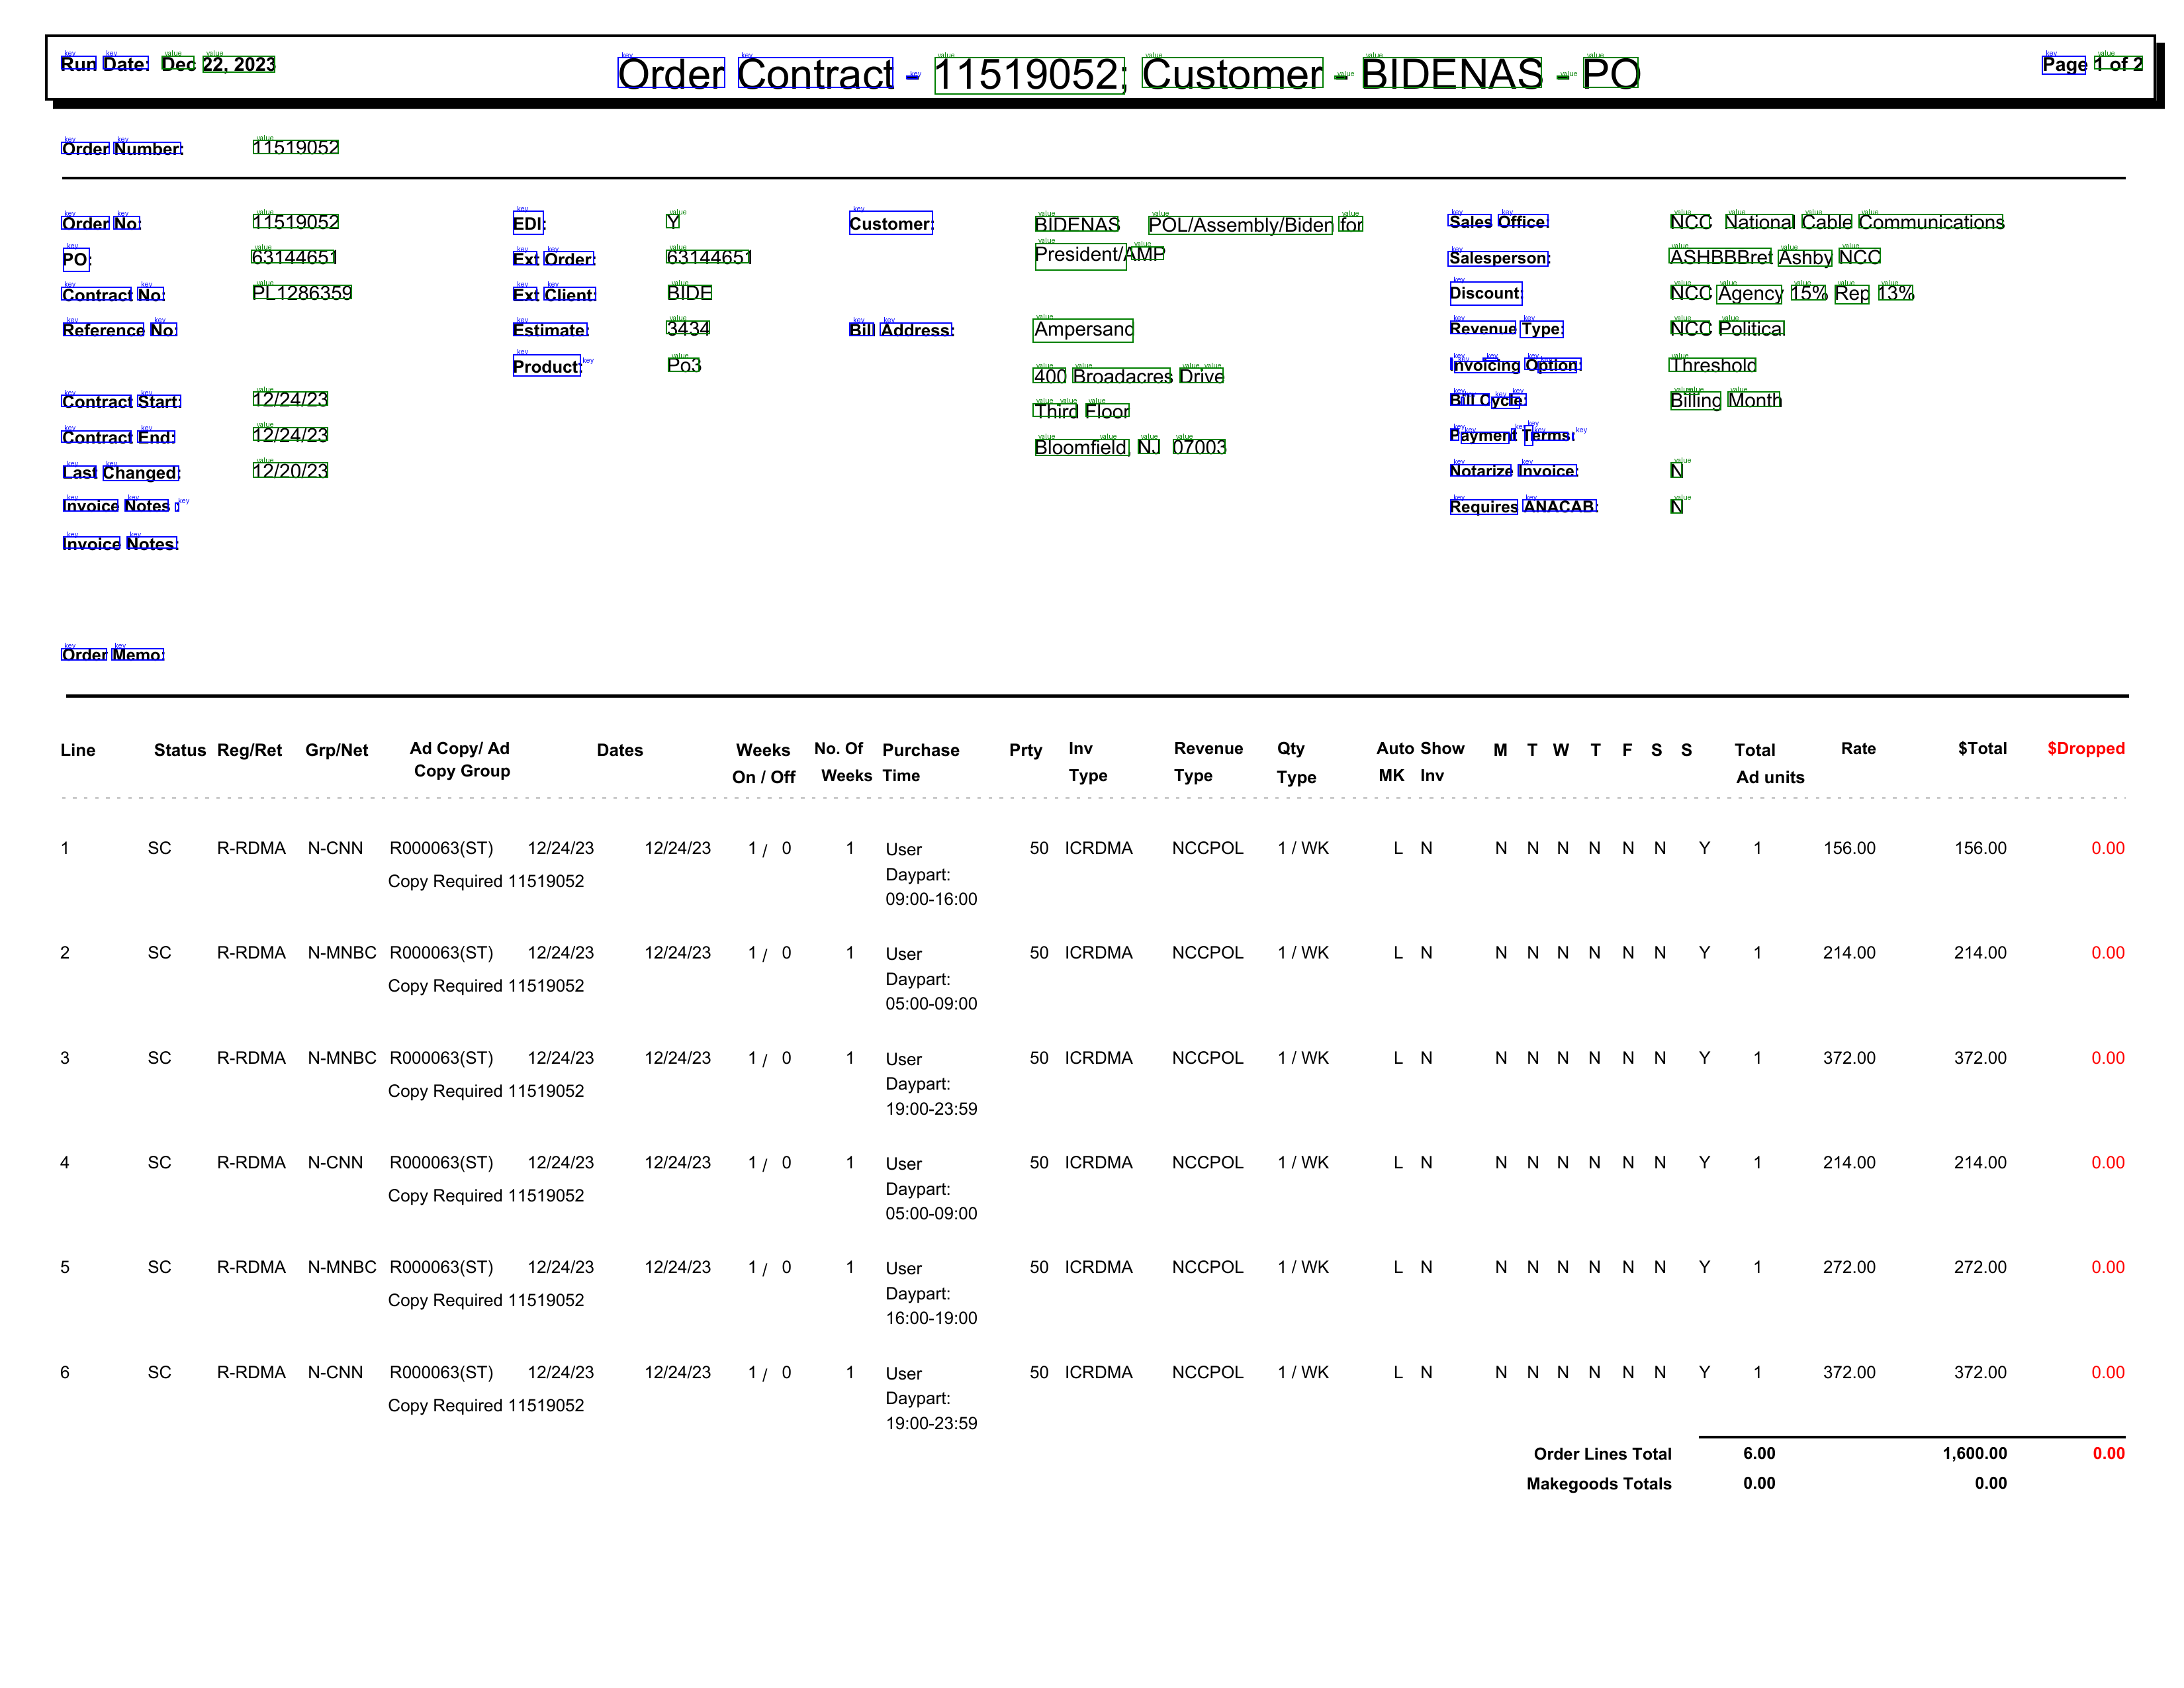

✅ Ground Truth:


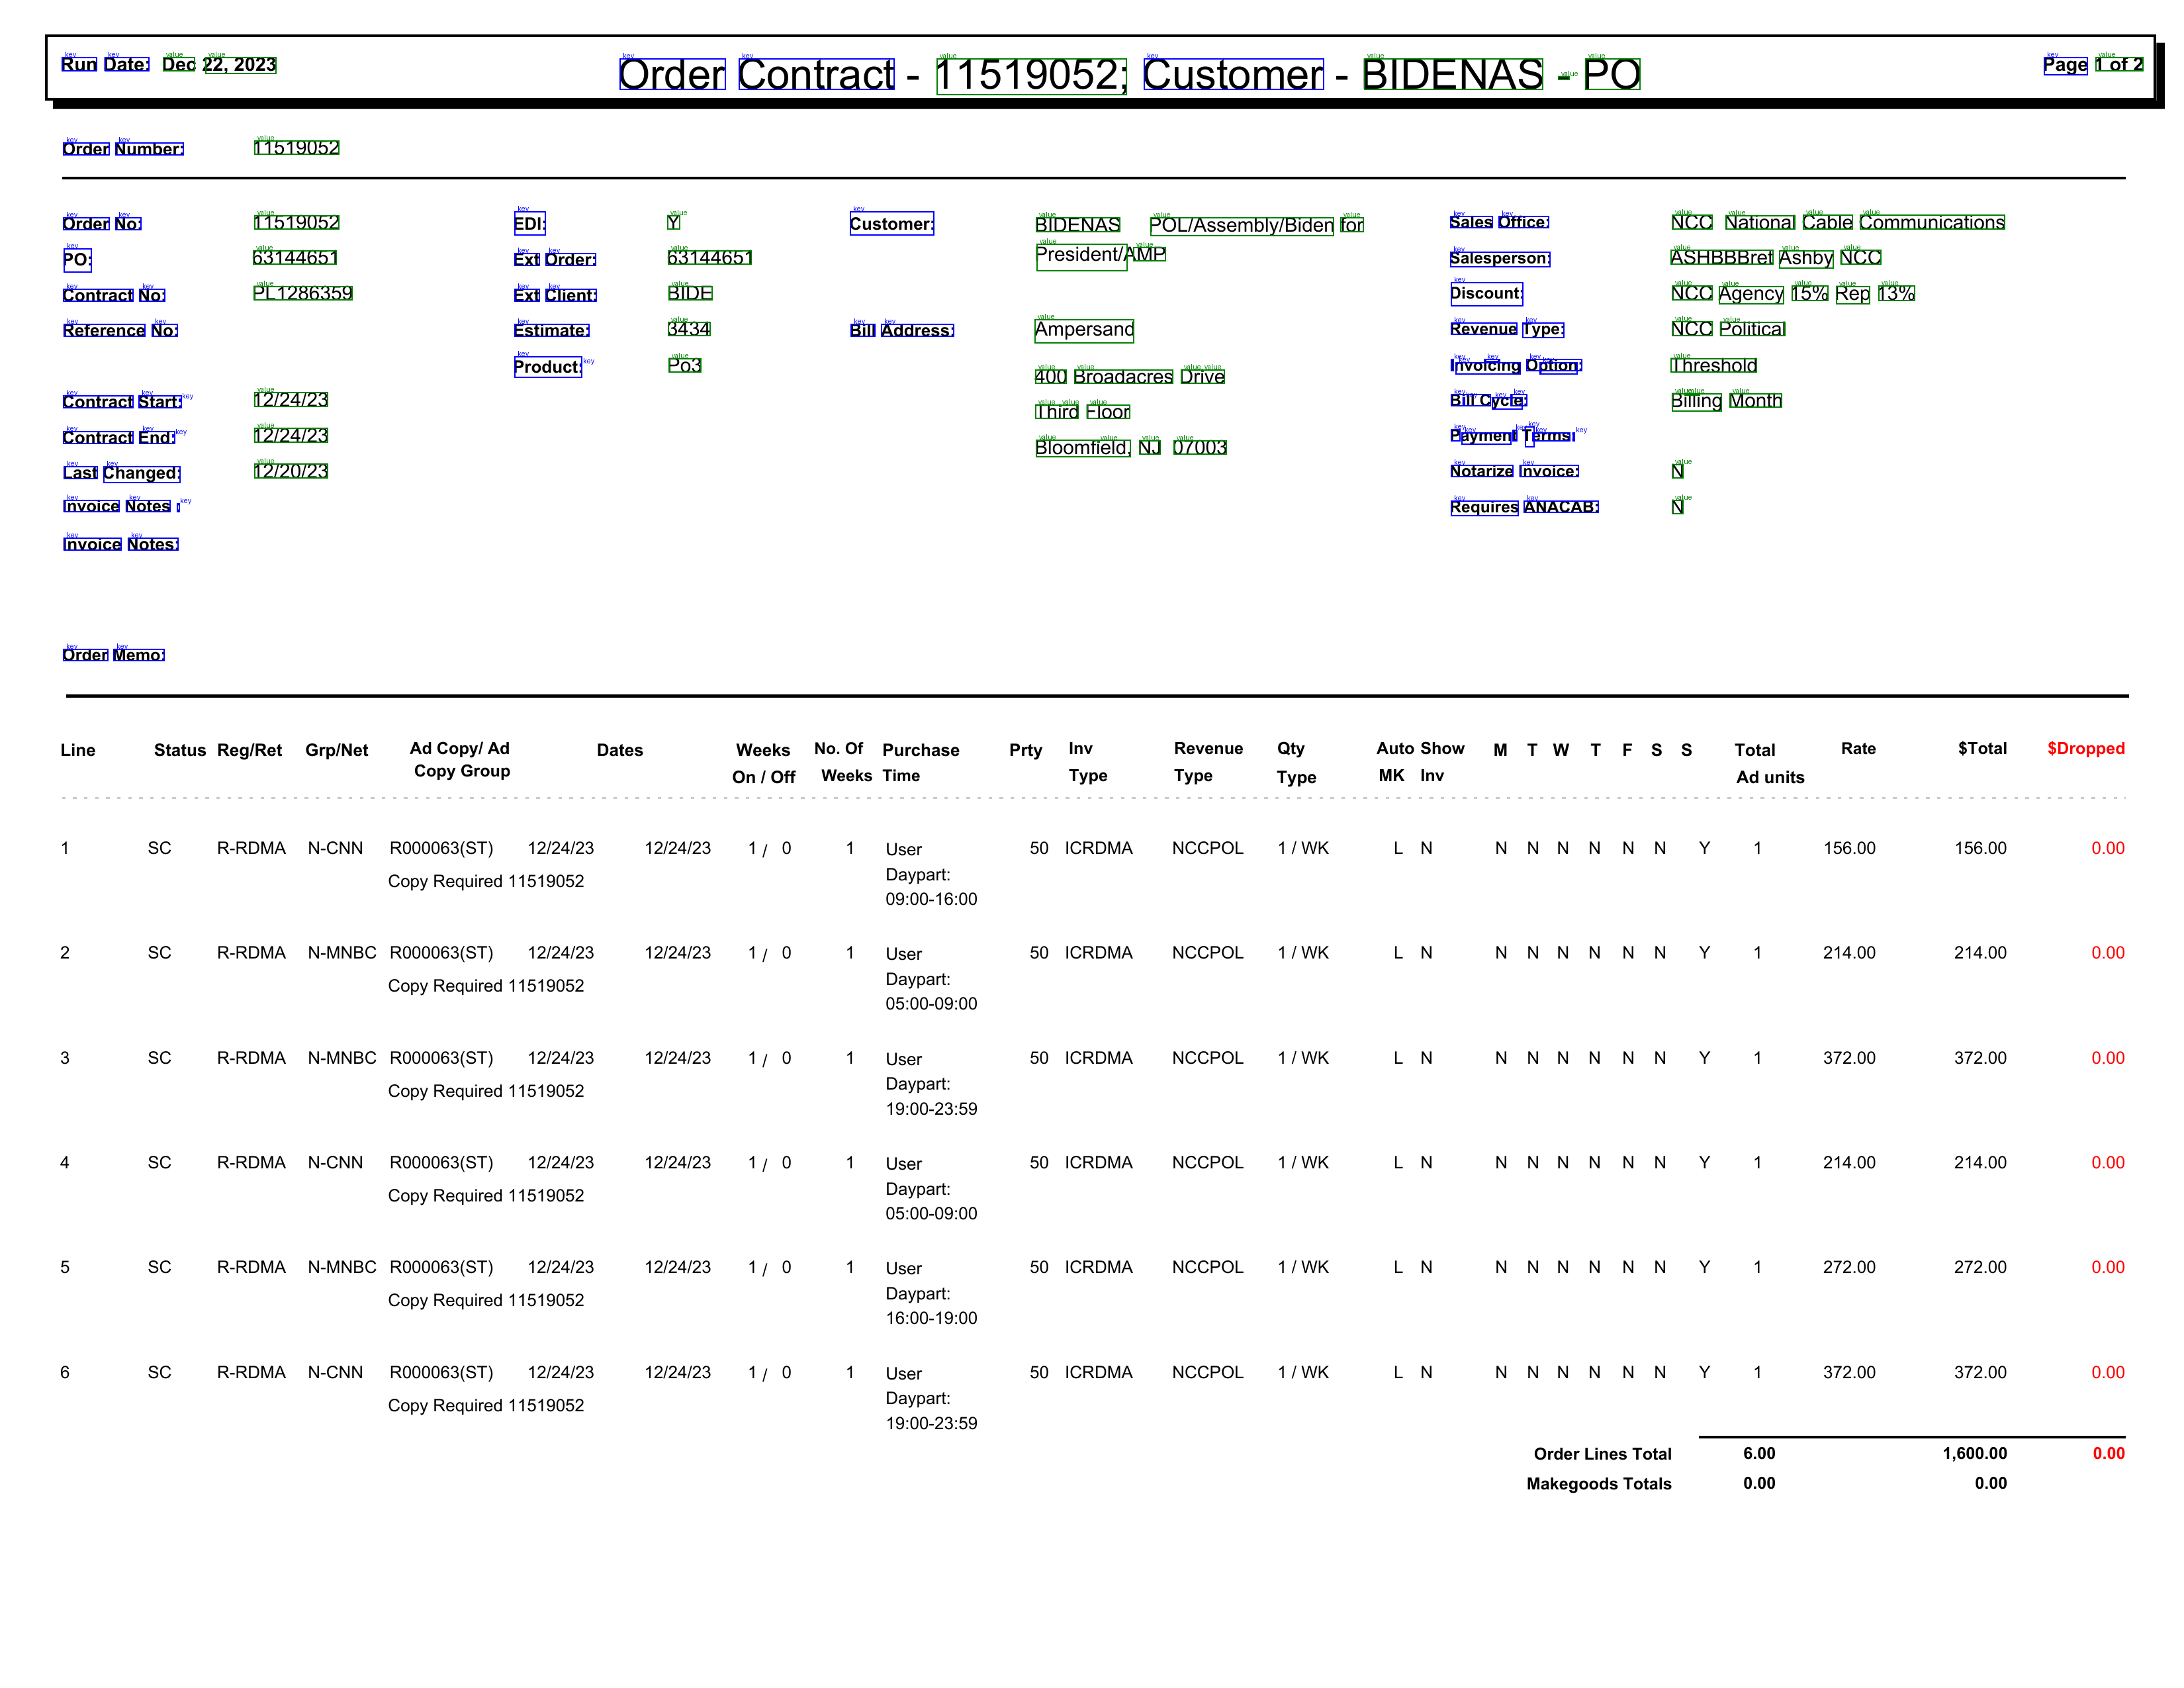

In [16]:
#predict_and_visualize("aaf643426f0250efd10de3d9df63b407292f3fcc2aa335e399c37aca32443ea1")
#predict_and_visualize("aaed61e79aa3edbae844f5775789ebb6aa1a94a23d9cb3468d2cfc974af304e5")
predict_and_visualize("aa35720ba3611f946c372cc99d8cd1d78e81265b8ceb51dcdb4672d196944c2b")


_______